# **Brain MRI image generation using DCGAN**
---


# 🔧 **Setup and Imports** 

Let's begin by setting up the necessary libraries and importing the dataset.  

### 📦 **Installing Required Libraries**

In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
from tqdm import tqdm

manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
dataroot = "/kaggle/input/brain-mri-images-for-brain-tumor-detection" 

workers = 2
batch_size = 64
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 500
lr = 0.0002
beta1 = 0.5
ngpu = 1
  # Number of output channels (3 for RGB images)

duplicate

# 3. Dataset and DataLoader 

dataloader:  <enumerate object at 0x7cdb08fa3600>


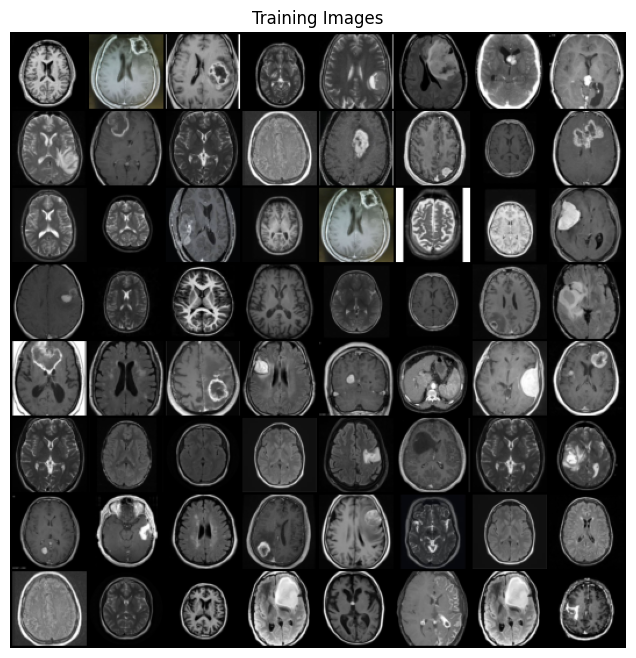

In [3]:

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
print("dataloader: ", enumerate(dataloader))

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# 4. Neural Networks Architecture 

 DCGAN model.

---

## 4.1 Generator 🎨



In [5]:

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
       
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
     
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
    
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
          
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
           
        )

    def forward(self, input):
        return self.main(input)


In [6]:

netG = Generator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## 4.2 Discriminator 


In [7]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
       
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
    
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
      
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
       
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [8]:

netD = Discriminator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [9]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## 5. Training Loop 


In [10]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        iters += 1
        
        if iters % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (epoch == 300):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            output_path = '/kaggle/working/DCGAN_results_epoch_300/'
            if not os.path.exists(output_path):
                os.makedirs(output_path)
            
            for i in range(64):
                vutils.save_image(fake[i], '%s/fake_samples_epoch_300_%d.png' %
                                  (output_path, i), normalize=True)


Starting Training Loop...
[6/500][1/8]	Loss_D: 0.0449	Loss_G: 8.2567	D(x): 0.9635	D(G(z)): 0.0003 / 0.0004
[12/500][3/8]	Loss_D: 0.6992	Loss_G: 9.9239	D(x): 0.9178	D(G(z)): 0.4010 / 0.0001
[18/500][5/8]	Loss_D: 0.0713	Loss_G: 7.4348	D(x): 0.9368	D(G(z)): 0.0031 / 0.0014
[24/500][7/8]	Loss_D: 0.1725	Loss_G: 6.5024	D(x): 0.9373	D(G(z)): 0.0934 / 0.0018
[31/500][1/8]	Loss_D: 0.0587	Loss_G: 4.6274	D(x): 0.9738	D(G(z)): 0.0282 / 0.0120
[37/500][3/8]	Loss_D: 0.1605	Loss_G: 7.0512	D(x): 0.9276	D(G(z)): 0.0704 / 0.0017
[43/500][5/8]	Loss_D: 0.1895	Loss_G: 8.7501	D(x): 0.9642	D(G(z)): 0.1290 / 0.0003
[49/500][7/8]	Loss_D: 2.6228	Loss_G: 19.3019	D(x): 0.2769	D(G(z)): 0.0000 / 0.0000
[56/500][1/8]	Loss_D: 0.4289	Loss_G: 11.2340	D(x): 0.9109	D(G(z)): 0.1803 / 0.0001
[62/500][3/8]	Loss_D: 0.0975	Loss_G: 9.6032	D(x): 0.9944	D(G(z)): 0.0808 / 0.0002
[68/500][5/8]	Loss_D: 0.1154	Loss_G: 7.3805	D(x): 0.9631	D(G(z)): 0.0703 / 0.0010
[74/500][7/8]	Loss_D: 0.0802	Loss_G: 6.7303	D(x): 0.9632	D(G(z)): 0.038

In [11]:
print(f"Real image shape: {real_cpu.shape}")   # Should be [batch_size, nc, 64, 64]
print(f"Fake image shape: {fake.shape}")       # Should be [batch_size, nc, 64, 64]


Real image shape: torch.Size([58, 3, 64, 64])
Fake image shape: torch.Size([58, 3, 64, 64])


## 6. Results and Visualization 



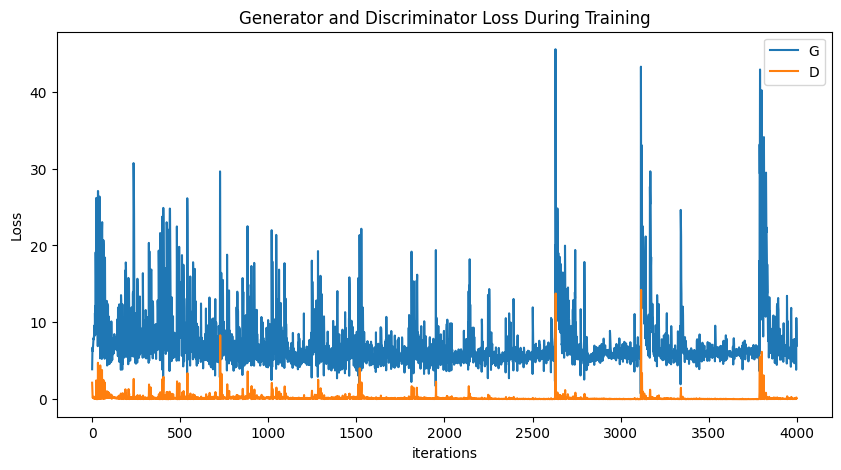

In [12]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

##  Visualizing the Generated Images


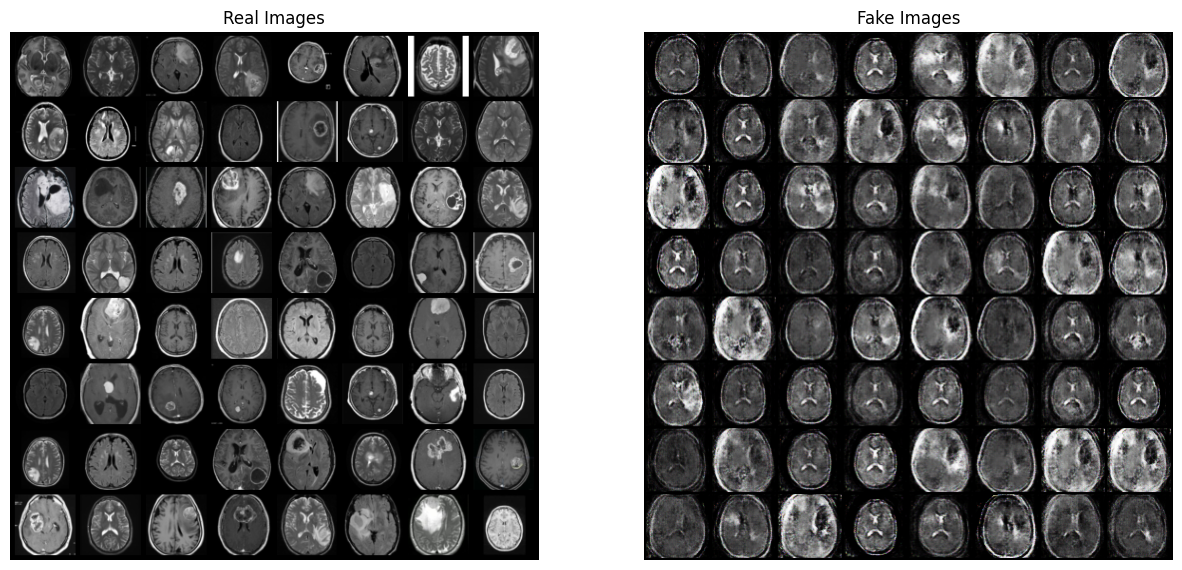

In [13]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))


plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()  

**Brain tumor Classification: **
Train the classification network using real and genrated images and compute the training loss and and training accuracy.

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Enable CUDA debugging for better error messages
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

def clear_cuda_cache():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Custom dataset class for loading MRI images
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_mapping = {'no': 0, 'yes': 1}

        for label in ['no', 'yes']:
            label_dir = os.path.join(root_dir, label)
            if os.path.exists(label_dir):
                for img_name in os.listdir(label_dir):
                    if img_name.endswith('.jpg') or img_name.endswith('.png'):
                        img_path = os.path.join(label_dir, img_name)
                        self.images.append(img_path)
                        self.labels.append(self.class_mapping[label])

        # Ensure labels are valid and long integers
        self.labels = torch.tensor(self.labels, dtype=torch.long)
        assert self.labels.min() >= 0 and self.labels.max() < 2, "Invalid labels detected!"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

# Custom dataset class for GAN-generated images (Labeled as `-1`, adjusted for training)
class GANDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []  # Assign random binary labels for synthetic dataset

        if os.path.exists(root_dir):
            for img_name in os.listdir(root_dir):
                if img_name.endswith('.jpg') or img_name.endswith('.png'):
                    img_path = os.path.join(root_dir, img_name)
                    self.images.append(img_path)
                    self.labels.append(np.random.randint(0, 2))  # Assign 0 or 1 randomly

        self.labels = torch.tensor(self.labels, dtype=torch.long)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

# Load datasets
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

real_data_path = "/kaggle/input/brain-mri-images-for-brain-tumor-detection"
gan_data_path = "/kaggle/working/DCGAN_results_epoch_300"

if os.path.exists(real_data_path):
    real_dataset = BrainTumorDataset(root_dir=real_data_path, transform=transform)
    print(f"Loaded {len(real_dataset)} real MRI images.")
else:
    print(f"Error: Real dataset path {real_data_path} does not exist!")

if os.path.exists(gan_data_path):
    synthetic_dataset = GANDataset(root_dir=gan_data_path, transform=transform)
    print(f"Loaded {len(synthetic_dataset)} synthetic MRI images.")
else:
    print(f"Error: Synthetic dataset path {gan_data_path} does not exist!")

# Merge real dataset for training
merged_dataset = real_dataset  # Merge 'yes' and 'no' categories into one dataset for training
batch_size = 32

real_dataloader = DataLoader(real_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
synthetic_dataloader = DataLoader(synthetic_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
merged_dataloader = DataLoader(merged_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Define the CNN classification model with dropout and batch normalization
class BrainTumorClassifier(nn.Module):
    def __init__(self):
        super(BrainTumorClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

# Training function
def train_model(model, dataloader, criterion, optimizer, num_epochs=10, device='cuda'):
    clear_cuda_cache()
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device, dtype=torch.long)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}, Accuracy: {100 * correct / total:.2f}%')

# Initialize model, loss, optimizer
model = BrainTumorClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Training on Merged Real MRI Data...")
train_model(model, merged_dataloader, criterion, optimizer, num_epochs=100, device=device)

print("Training on Synthetic MRI Data...")
train_model(model, synthetic_dataloader, criterion, optimizer, num_epochs=100, device=device)


Loaded 173 real MRI images.
Loaded 64 synthetic MRI images.
Training on Merged Real MRI Data...
Epoch [1/100], Loss: 1.2409, Accuracy: 53.76%
Epoch [2/100], Loss: 0.9130, Accuracy: 58.96%
Epoch [3/100], Loss: 0.7283, Accuracy: 67.63%
Epoch [4/100], Loss: 0.6494, Accuracy: 71.10%
Epoch [5/100], Loss: 0.5457, Accuracy: 72.25%
Epoch [6/100], Loss: 0.5707, Accuracy: 70.52%
Epoch [7/100], Loss: 0.5374, Accuracy: 76.88%
Epoch [8/100], Loss: 0.4921, Accuracy: 75.72%
Epoch [9/100], Loss: 0.4806, Accuracy: 76.30%
Epoch [10/100], Loss: 0.4794, Accuracy: 77.46%
Epoch [11/100], Loss: 0.4557, Accuracy: 79.19%
Epoch [12/100], Loss: 0.4289, Accuracy: 79.77%
Epoch [13/100], Loss: 0.4527, Accuracy: 78.61%
Epoch [14/100], Loss: 0.4529, Accuracy: 80.35%
Epoch [15/100], Loss: 0.4501, Accuracy: 79.19%
Epoch [16/100], Loss: 0.4522, Accuracy: 77.46%
Epoch [17/100], Loss: 0.4013, Accuracy: 80.35%
Epoch [18/100], Loss: 0.4226, Accuracy: 79.19%
Epoch [19/100], Loss: 0.3632, Accuracy: 83.24%
Epoch [20/100], Loss

Loaded 173 real MRI images.
Loaded 64 synthetic MRI images.
Training on Real MRI Data...
Real Epoch [1/50], Loss: 0.7023, Accuracy: 67.05%
Real Epoch [2/50], Loss: 0.8632, Accuracy: 63.01%
Real Epoch [3/50], Loss: 0.6870, Accuracy: 72.25%
Real Epoch [4/50], Loss: 0.6170, Accuracy: 71.10%
Real Epoch [5/50], Loss: 0.6484, Accuracy: 69.94%
Real Epoch [6/50], Loss: 0.6183, Accuracy: 71.10%
Real Epoch [7/50], Loss: 0.5485, Accuracy: 73.99%
Real Epoch [8/50], Loss: 0.4866, Accuracy: 79.19%
Real Epoch [9/50], Loss: 0.5051, Accuracy: 74.57%
Real Epoch [10/50], Loss: 0.4611, Accuracy: 75.72%
Real Epoch [11/50], Loss: 0.4525, Accuracy: 82.66%
Real Epoch [12/50], Loss: 0.4882, Accuracy: 77.46%
Real Epoch [13/50], Loss: 0.4671, Accuracy: 76.30%
Real Epoch [14/50], Loss: 0.4400, Accuracy: 78.03%
Real Epoch [15/50], Loss: 0.3545, Accuracy: 83.24%
Real Epoch [16/50], Loss: 0.4118, Accuracy: 82.08%
Real Epoch [17/50], Loss: 0.4408, Accuracy: 80.35%
Real Epoch [18/50], Loss: 0.4025, Accuracy: 79.77%
Re

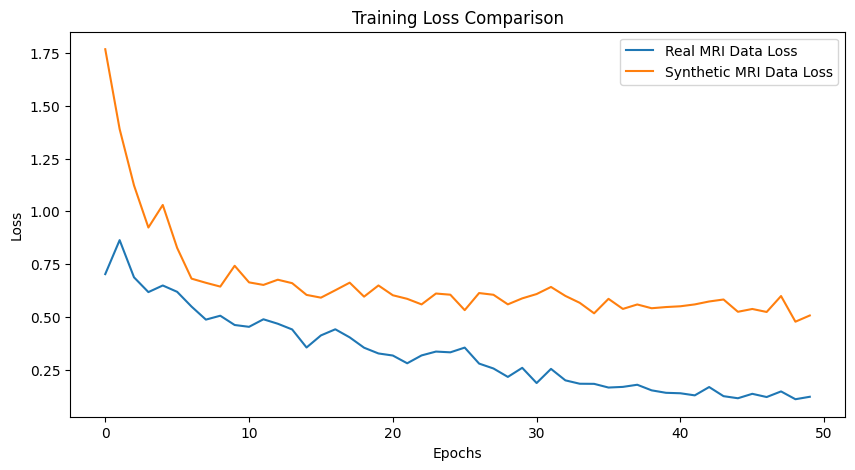

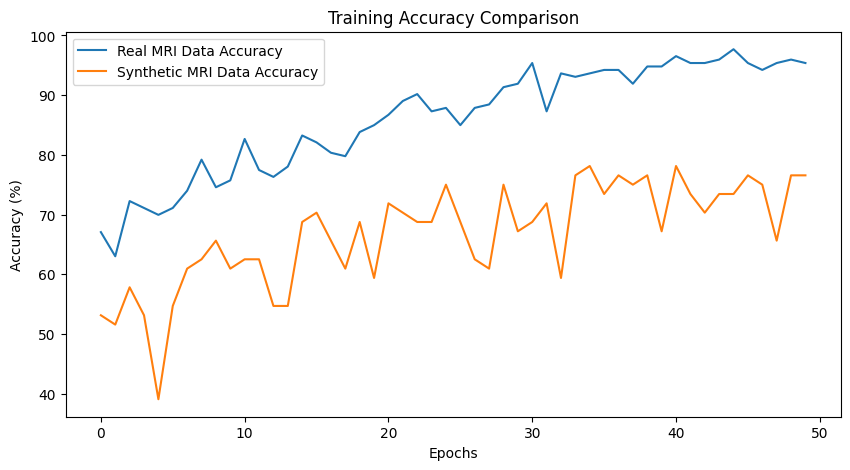

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Enable CUDA debugging for better error messages
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

def clear_cuda_cache():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Custom dataset class for loading MRI images
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_mapping = {'no': 0, 'yes': 1}

        for label in ['no', 'yes']:
            label_dir = os.path.join(root_dir, label)
            if os.path.exists(label_dir):
                for img_name in os.listdir(label_dir):
                    if img_name.endswith('.jpg') or img_name.endswith('.png'):
                        img_path = os.path.join(label_dir, img_name)
                        self.images.append(img_path)
                        self.labels.append(self.class_mapping[label])

        self.labels = torch.tensor(self.labels, dtype=torch.long)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

# Custom dataset class for GAN-generated images (Labeled as `-1`, adjusted for training)
class GANDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []  

        if os.path.exists(root_dir):
            for img_name in os.listdir(root_dir):
                if img_name.endswith('.jpg') or img_name.endswith('.png'):
                    img_path = os.path.join(root_dir, img_name)
                    self.images.append(img_path)
                    self.labels.append(np.random.randint(0, 2))  

        self.labels = torch.tensor(self.labels, dtype=torch.long)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

# Load datasets
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

real_data_path = "/kaggle/input/brain-mri-images-for-brain-tumor-detection"
gan_data_path = "/kaggle/working/DCGAN_results_epoch_300"

if os.path.exists(real_data_path):
    real_dataset = BrainTumorDataset(root_dir=real_data_path, transform=transform)
    print(f"Loaded {len(real_dataset)} real MRI images.")
else:
    print(f"Error: Real dataset path {real_data_path} does not exist!")

if os.path.exists(gan_data_path):
    synthetic_dataset = GANDataset(root_dir=gan_data_path, transform=transform)
    print(f"Loaded {len(synthetic_dataset)} synthetic MRI images.")
else:
    print(f"Error: Synthetic dataset path {gan_data_path} does not exist!")

batch_size = 32
real_dataloader = DataLoader(real_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
synthetic_dataloader = DataLoader(synthetic_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Define the CNN classification model
class BrainTumorClassifier(nn.Module):
    def __init__(self):
        super(BrainTumorClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

# Training function
def train_model(model, dataloader, criterion, optimizer, num_epochs=10, device='cuda', dataset_name="Real"):
    clear_cuda_cache()
    model.to(device)
    losses, accuracies = [], []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device, dtype=torch.long)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        epoch_loss = running_loss / len(dataloader)
        epoch_accuracy = 100 * correct / total
        losses.append(epoch_loss)
        accuracies.append(epoch_accuracy)

        print(f'{dataset_name} Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')
    
    return losses, accuracies

# Initialize model, loss, optimizer
model = BrainTumorClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Training on Real MRI Data...")
real_losses, real_accuracies = train_model(model, real_dataloader, criterion, optimizer, num_epochs=50, device=device, dataset_name="Real")

print("Training on Synthetic MRI Data...")
synthetic_losses, synthetic_accuracies = train_model(model, synthetic_dataloader, criterion, optimizer, num_epochs=50, device=device, dataset_name="Synthetic")

# Plot Training Loss
plt.figure(figsize=(10,5))
plt.plot(real_losses, label="Real MRI Data Loss")
plt.plot(synthetic_losses, label="Synthetic MRI Data Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.show()

# Plot Training Accuracy
plt.figure(figsize=(10,5))
plt.plot(real_accuracies, label="Real MRI Data Accuracy")
plt.plot(synthetic_accuracies, label="Synthetic MRI Data Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy Comparison")
plt.legend()
plt.show()
